<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

Загружаем данные:
'creditcard.csv'

In [2]:
# загрузка данных и структура данных
df=pd.read_csv('/content/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


Небольшой описательный анализ, используя метод describe()

In [3]:
# анализ данных
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,89220.000000,89220.000000,89220.000000,89220.000000,89220.000000,89220.000000,89220.000000,89220.000000,89220.000000,89219.000000,...,89219.000000,89219.000000,89219.000000,89219.000000,89219.000000,89219.000000,89219.000000,89219.000000,89219.000000,89219.000000
mean,39715.015501,-0.265000,-0.039318,0.678729,0.162808,-0.278291,0.094282,-0.109561,0.054698,-0.028905,...,-0.029895,-0.106761,-0.037413,0.009718,0.132571,0.027095,0.001317,0.002412,98.532339,0.002365
std,16026.485819,1.873458,1.662182,1.352995,1.359523,1.370149,1.302130,1.230881,1.215535,1.129755,...,0.727551,0.634882,0.625389,0.594412,0.441100,0.496667,0.389659,0.326436,266.941369,0.048574
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-26.751119,-2.836627,-7.495741,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,32165.000000,-1.028772,-0.603310,0.182821,-0.719037,-0.897378,-0.646335,-0.601120,-0.139866,-0.692643,...,-0.223859,-0.526395,-0.177767,-0.322006,-0.131948,-0.325915,-0.063273,-0.005744,7.675000,0.000000
50%,42017.000000,-0.262209,0.071676,0.760383,0.185833,-0.313066,-0.156213,-0.070878,0.071465,-0.102804,...,-0.057810,-0.082239,-0.049619,0.064928,0.171090,-0.070776,0.009396,0.023123,26.990000,0.000000
75%,52274.250000,1.152744,0.727352,1.386516,1.037554,0.254270,0.488962,0.416670,0.355072,0.589973,...,0.118714,0.309107,0.081203,0.406088,0.420191,0.306496,0.082733,0.076409,89.950000,0.000000
max,62480.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,22.614889,10.503090,18.946734,4.014444,5.525093,3.517346,12.152401,33.847808,19656.530000,1.000000


Проверим на наличие пропусков в данных.

In [4]:
# проверка наличия пропусков в данных
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,1



Пропусков нет?

Выведем названия столбцов.

In [5]:
# названия столбцов
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Еще раз оценим отношение классов целевой переменной.

In [6]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении
df["Class"].value_counts()

,count
Class,
0.0,89008
1.0,211


In [7]:
# df['Class'].value_counts()  - возвращает словарик,
# где ключ - уникальные значения в столбце Class кол-во значений
# value - сколько всего записей имело эти значения
vc = df['Class'].value_counts()
c1 = vc[0]
c2 = vc[1]
print(c1,c2)

# так как это словарь, то чтобы получить значения, обращаемся по ключу:


89008 211


In [8]:
#  вывод отношения классов целевой переменной, но записанный через f строку

c = c1+c2
n_trans = c1/c # ваш код здесь, вместо None запишите формулу
f_trans = c2/c # ваш код здесь, вместо None запишите формулу

print(f'Обычные транзакции составляют  {n_trans} % данных')
print(f'Мошеннические транзакции составляют  {f_trans} % данных')

Обычные транзакции составляют  0.9976350328965803 % данных
Мошеннические транзакции составляют  0.002364967103419675 % данных


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

Text(0.5, 1.0, 'Распределение классов \n (0: Не мошенник || 1: Мошенник)')

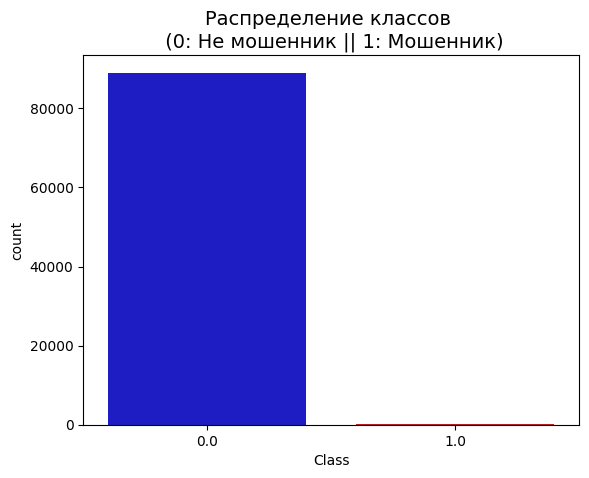

In [9]:
colors = ["#0101DF", "#DF0101"]

 # строим гистограмму целевой переменной:

sns.countplot(x=df["Class"], palette = colors)
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)


Построим распределения по суммам и времени транзакций.

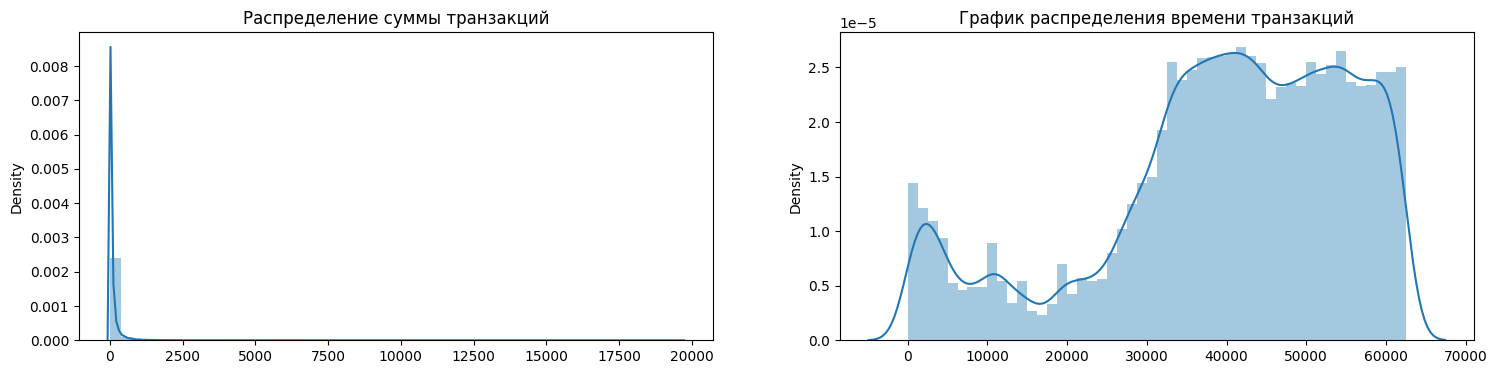

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.distplot(ax=ax[0], x=df['Amount'])
sns.distplot(ax=ax[1], x=df['Time'])

ax[0].set_title("Распределение суммы транзакций")
ax[1].set_title("График распределения времени транзакций")
plt.show()

### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [11]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.fit_transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.fit_transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  0.     8.94  38.42 ...  30.15   9.9  113.75]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  0.  ]
 [  8.94]
 [ 38.42]
 ...
 [ 30.15]
 [  9.9 ]
 [113.75]] 

Распределение классов: 

Обучающий набор: [0.99781439 0.00218561]
Тестовый набор: [9.96861690e-01 3.08226855e-03 5.60412464e-05]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [12]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем первые 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
23863,32957,-9.011188,4.841533,-7.057692,1.400410,-5.685523,-1.511191,-3.393503,5.839468,-0.084614,...,0.253366,-0.085300,-0.211253,0.411168,-0.146128,-0.369248,0.152133,-0.059393,89.99,0.0
43624,41582,-1.048005,1.300219,-0.180401,2.589843,-1.164794,0.031823,-2.175778,0.699072,-1.140208,...,0.549014,0.624321,-0.136663,0.131738,0.030921,-0.176701,0.504898,0.069882,39.45,1.0
15451,26833,-20.532751,12.373989,-23.009003,6.144821,-15.587296,-4.384491,-15.939003,13.696416,-3.948455,...,1.754608,-1.466115,-0.856779,0.125777,1.402587,-0.223755,1.574249,0.469201,99.99,1.0
41344,40642,0.754915,-1.760403,0.884246,-0.294640,-1.660639,0.538209,-0.981223,0.291693,-0.097285,...,0.233541,0.240874,-0.199888,0.049455,0.171578,-0.257883,0.015179,0.055785,268.60,0.0
73475,55151,-1.933383,-1.456943,2.510036,-1.444307,0.216649,-1.297811,-1.138839,0.174311,-1.077102,...,0.483315,1.147641,-0.385061,0.587006,0.379512,-0.168074,-0.003092,0.129105,49.99,0.0


In [13]:
# сохраняем полный набор данных
df.to_csv("/content/creditcard_full.csv")

In [14]:
new_df.shape

(703, 31)

Распределение классов в подвыборке


Text(0.5, 1.0, 'Распределение классов')

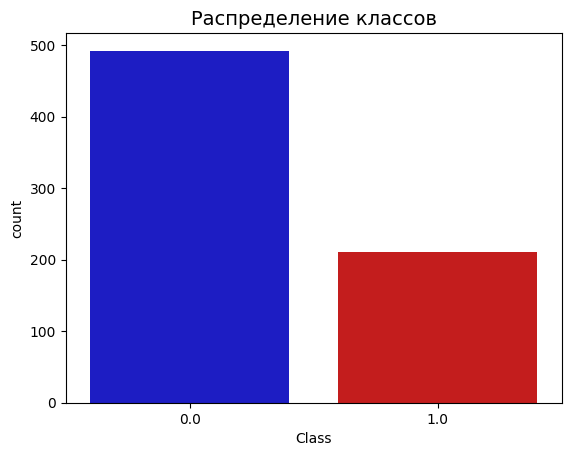

In [15]:
print('Распределение классов в подвыборке')


# проверяем снова распределение целевой переменной
sns.countplot(x=new_df["Class"], palette = colors)
plt.title('Распределение классов', fontsize=14)

### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


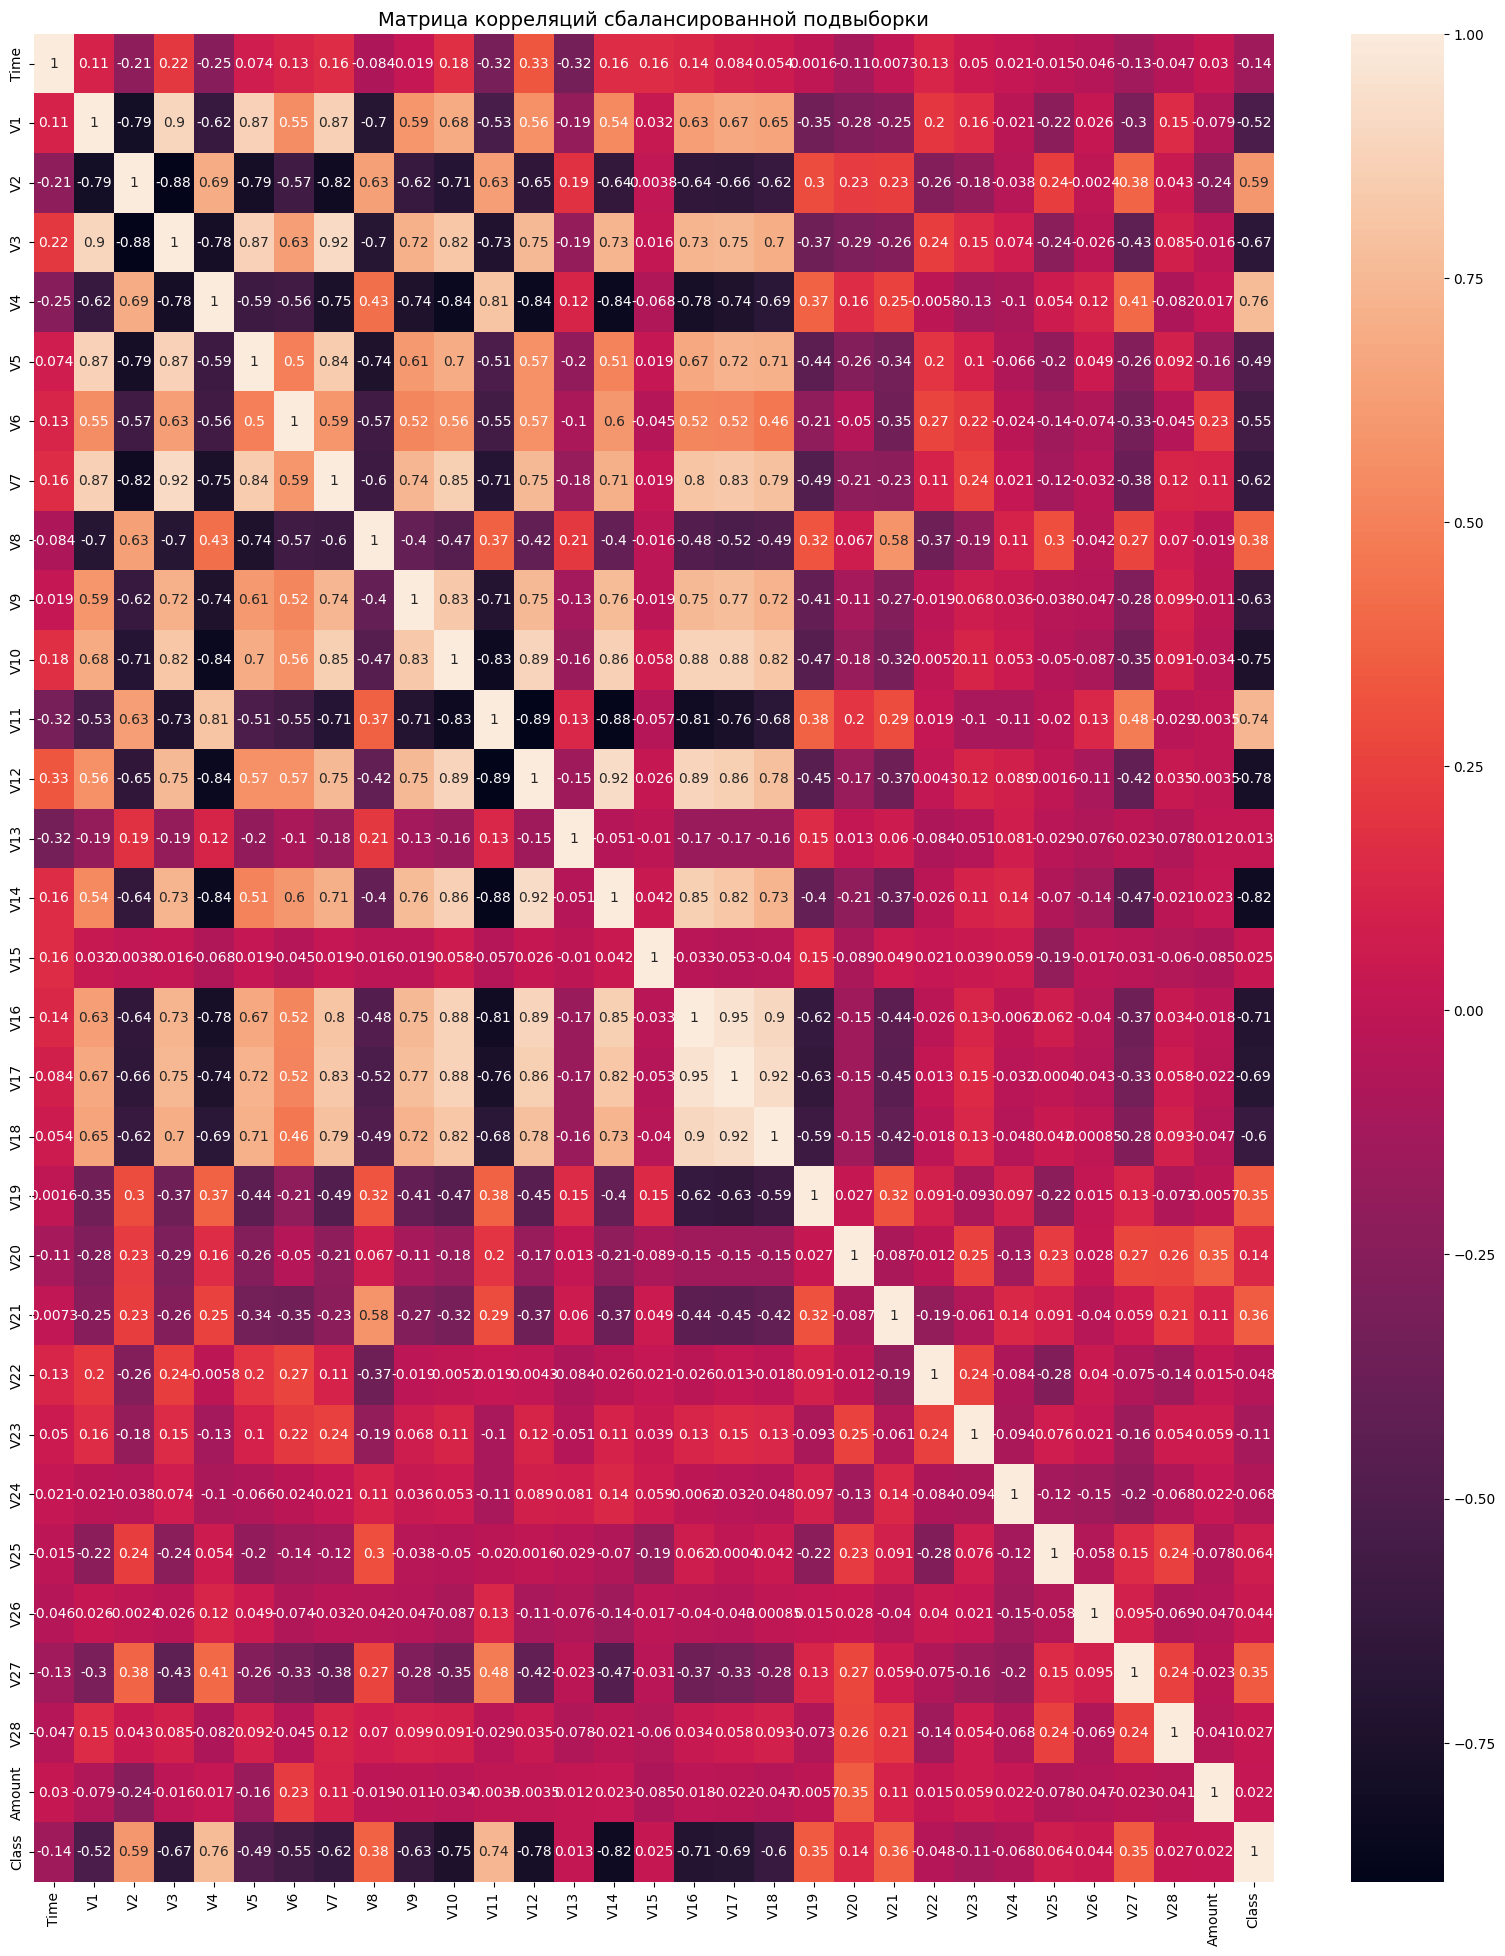

In [16]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций
sns.heatmap(new_df.corr(numeric_only = True), annot=True)
ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.show()

### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Какие признаки  имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Какие признаки  положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!**

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

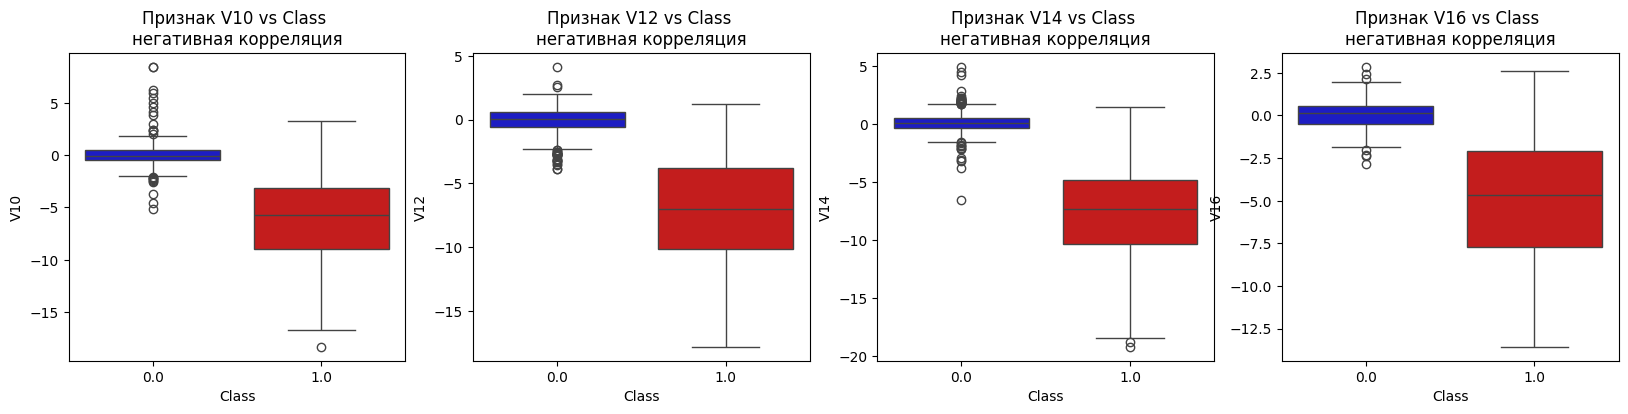

In [17]:
def plt_boxplot(y, t):
  f, axes = plt.subplots(ncols=4, figsize=(20,4))
  s = "негативная корреляция" if t == 1 else "Положительная корреляция"
  #
  sns.boxplot(x="Class",y = y[0],data = new_df,ax=axes[0], palette = colors)
  axes[0].set_title("Признак " + y[0] + " vs Class " + '\n'+ s)
  #
  sns.boxplot(x="Class",y = y[1],data = new_df,ax=axes[1], palette = colors)
  axes[1].set_title("Признак " + y[1] + " vs Class " + '\n'+ s)
  #
  sns.boxplot(x="Class",y = y[2],data = new_df,ax=axes[2], palette = colors)
  axes[2].set_title("Признак " + y[2] + " vs Class " + '\n'+ s)
  #
  sns.boxplot(x="Class",y = y[3],data = new_df,ax=axes[3], palette = colors)
  axes[3].set_title("Признак " + y[3] + " vs Class " + '\n'+ s)
  plt.show()

# признаки с отриц корреляцией
neg = ["V10", "V12", "V14", "V16"]
# признаки с положит корреляцией
pos = ["V2", "V4", "V11", "V19"]

plt_boxplot(neg,1)
# Отрицательные корреляции

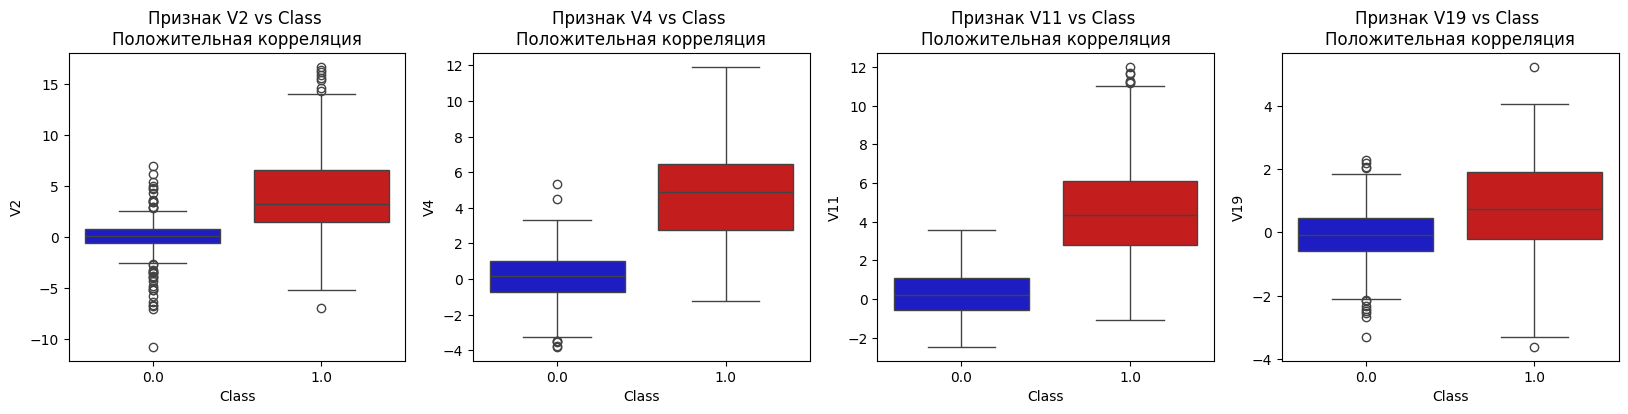

In [18]:
plt_boxplot(pos,2)

# Положительные корреляции V2, V4, V11, V19



# Какие выводы можно сделать по построенным Boxplot?

Напоминаю.

0 - это не мошеннические транзакции

1 - мошеннические транзакции

Вывод: Выбросов больше в не мошеннеческих транзакциях

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

In [19]:
from scipy.stats import norm

def plt_distplot(y, t):
  f, axes = plt.subplots(ncols=4, figsize=(20,4))
  s = "Негативная корреляция" if t == 1 else "Положительная корреляция"
  #
  sns.distplot(new_df[y[0]],ax = axes[0],fit=norm)
  axes[0].set_title("Распределение для признака " + y[0] + '\n' + s)
  #
  sns.distplot(new_df[y[1]],ax = axes[1],fit=norm)
  axes[1].set_title("Распределение для признака  " + y[1] + '\n' + s)
  #
  sns.distplot(new_df[y[2]],ax = axes[2],fit=norm)
  axes[2].set_title("Распределение для признака  " + y[2] + '\n' + s)
  #
  sns.distplot(new_df[y[3]],ax = axes[3],fit=norm)
  axes[3].set_title("Распределение для признака  " + y[3] + '\n' + s)
  plt.show()

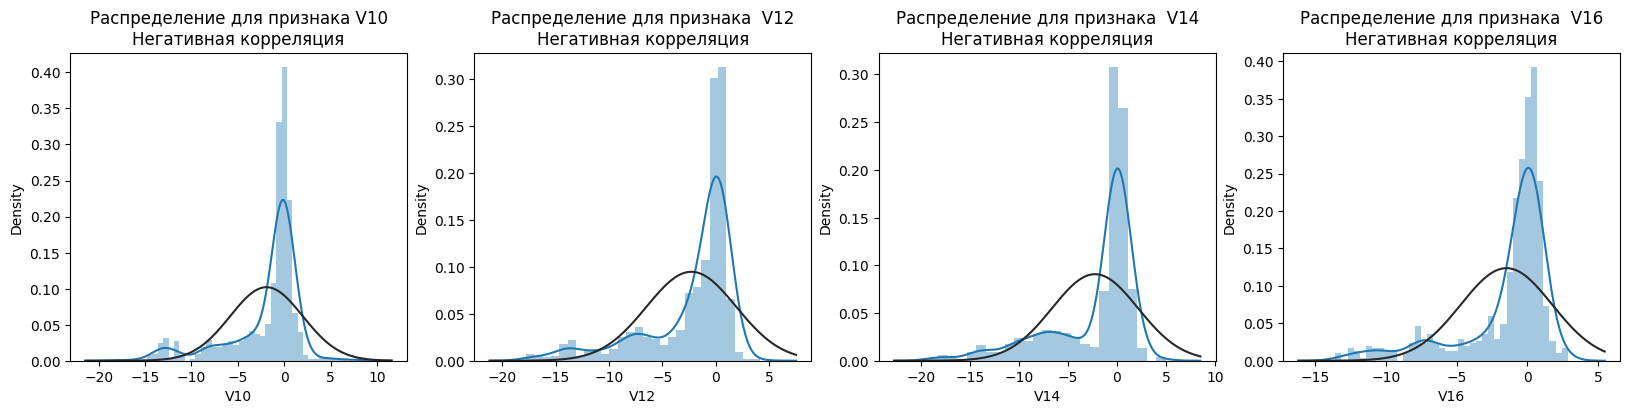

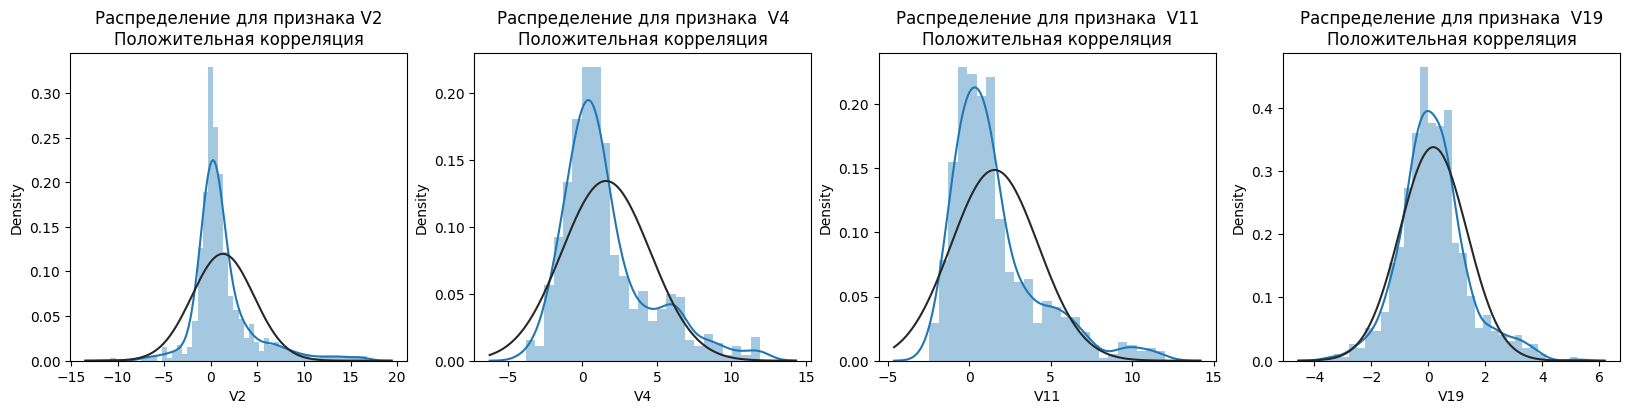

In [20]:
# Строим распределения для признаков с отрицательной корреляцией
plt_distplot(neg,1)

# Строим распределения для признаков с положительной корреляцией
plt_distplot(pos,2)

In [21]:
#функция, в качастве параметра которой будут вытупать выбросы других признаков
def del_fraud_column(column,new_df):
  # Удаление выбросов из признака V
  v_fraud = new_df[column].loc[new_df['Class'] == 1].values
  q25, q75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
  print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
  v_iqr = q75 - q25
  print('iqr: {}'.format(v_iqr))

  v_cut_off = v_iqr * 1.5
  v_lower, v_upper = q25 - v_cut_off, q75 + v_cut_off
  print('Порог: {}'.format(v_cut_off))
  print(column, ' нижняя граница: {}'.format(v_lower))
  print(column, ' верхняя граница: {}'.format(v_upper))

  outliers = [x for x in v_fraud if x < v_lower or x > v_upper]
  print('Количество выбросов: {}'.format(len(outliers)))

  new_df_without_outliers = new_df[(new_df[column] > v_upper) | (new_df[column] < v_lower)].index.to_numpy()
  print('----' * 44)
  return new_df_without_outliers

In [22]:
del_rows=np.array([])

for f in new_df.columns:
  if f != 'Class':
    del_rows = np.union1d(del_rows,del_fraud_column(f,new_df))
new_df_without_outliers = new_df.drop(del_rows)

Квартиль 25: 20988.5 | Квартиль 75: 47874.5
iqr: 26886.0
Порог: 40329.0
Time  нижняя граница: -19340.5
Time  верхняя граница: 88203.5
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: -9.08557058419639 | Квартиль 75: -1.1057462660670399
iqr: 7.979824318129349
Порог: 11.969736477194024
V1  нижняя граница: -21.055307061390415
V1  верхняя граница: 10.863990211126984
Количество выбросов: 14
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: 1.45611819412714 | Квартиль 75: 6.53889997297746
iqr: 5.08278177885032
Порог: 7.62417266827548
V2  нижняя граница: -6.16805447414834
V2  верхняя граница: 14.16307264125294
Количество выбросов: 9
--------------------------------------------------------------

In [23]:
# Удаление выбросов из признака V17
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v17_iqr = q75 - q25
print('iqr: {}'.format(v17_iqr))

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('Порог: {}'.format(v17_cut_off))
print('V17 нижняя граница: {}'.format(v17_lower))
print('V17 верхняя граница: {}'.format(v17_upper))

outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Количество выбросов: {}'.format(len(outliers)))

new_df_without_outliers  = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('----' * 44)



#### Для остальных признаков на основе V17 описать функцию, в качастве параметра которой будут вытупать выбросы других признаков
### Написать вызов функции по нужным признакам

Квартиль 25: -13.35266495354235 | Квартиль 75: -3.92490541806518
iqr: 9.42775953547717
Порог: 14.141639303215754
V17 нижняя граница: -27.494304256758106
V17 верхняя граница: 10.216733885150575
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [24]:
len(new_df_without_outliers)

703

In [25]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = new_df_without_outliers

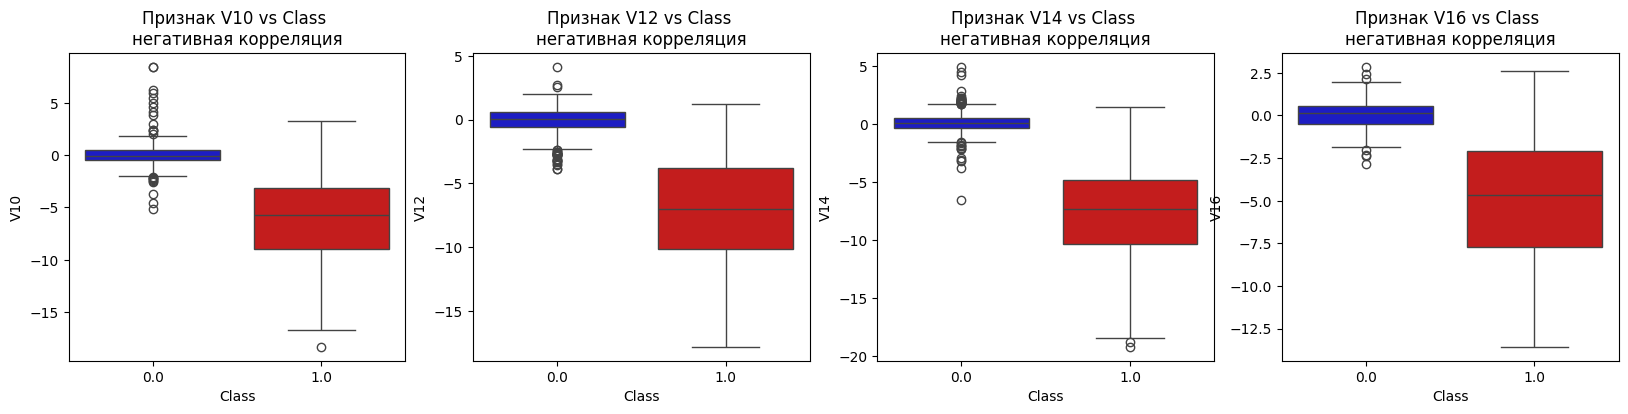

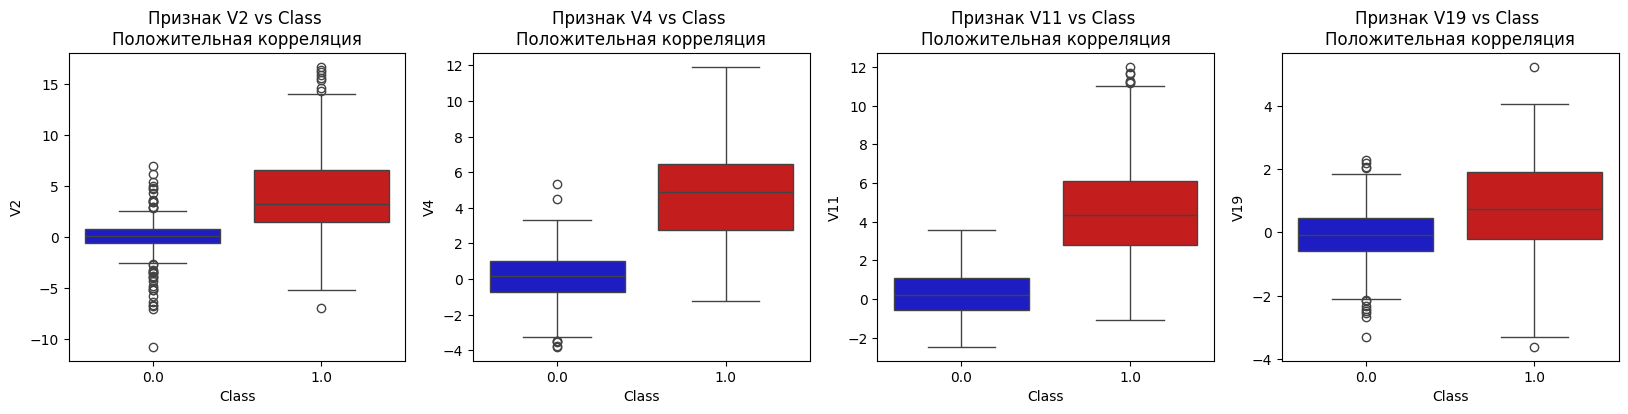

In [26]:
plt_boxplot(neg,1)
# Отрицательные корреляции
plt_boxplot(pos,2)
# Положительные корреляции V2, V4, V11, V19

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним понижение размерности с помощью трех различных техник понижения размерности.



In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
X_reduced_tsne = TSNE().fit_transform(X)

t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()

X_reduced_pca = PCA().fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()

X_reduced_svd = TruncatedSVD().fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 6.8 сек
PCA заняло 0.0033 сек
Truncated SVD заняло 0.0055 сек


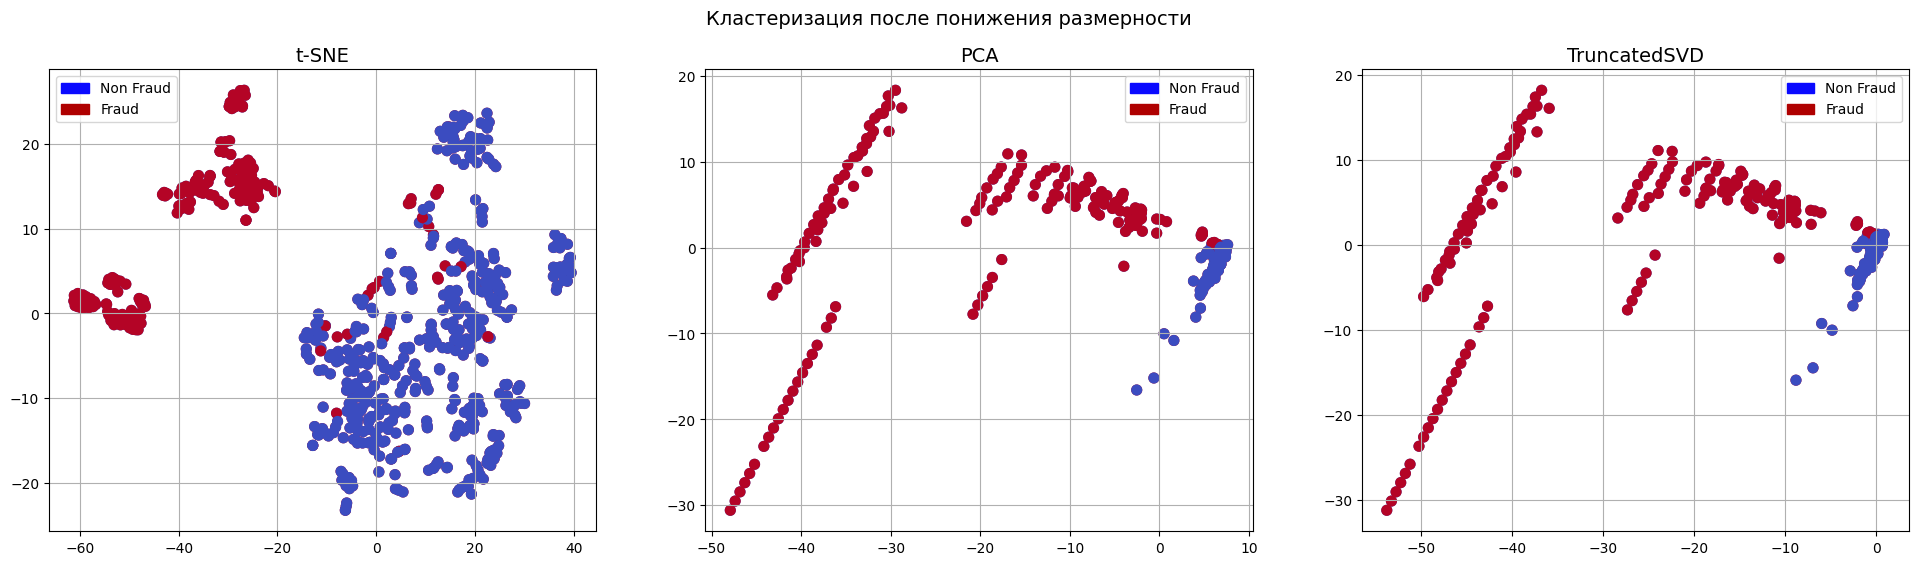

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])


# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('TruncatedSVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])


plt.show()

<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....



<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [30]:
new_df.to_csv('/content/creditcard_short.csv')